In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

In [49]:
BASE_DIR='/kaggle/input/utkface-new/UTKFace'

In [50]:
image_paths_split = os.listdir(BASE_DIR)

In [51]:
# AGE,GENDER AND ETHINICITY
image_paths=[]
age_labels=[]
gender_labels=[]
for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR,filename)
    temp=filename.split('_')
    age=int(temp[0])
    gender=int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [52]:
#convert to dataframe
df=pd.DataFrame()
df['image'],df['age'],df['gender']=image_paths,age_labels,gender_labels

In [53]:
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [54]:
# map labels for gender
gender_dict={0:'Male',1:'Female'}

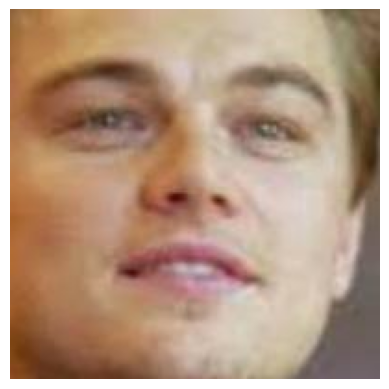

In [55]:
from PIL import Image
img= Image.open(df['image'][3])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

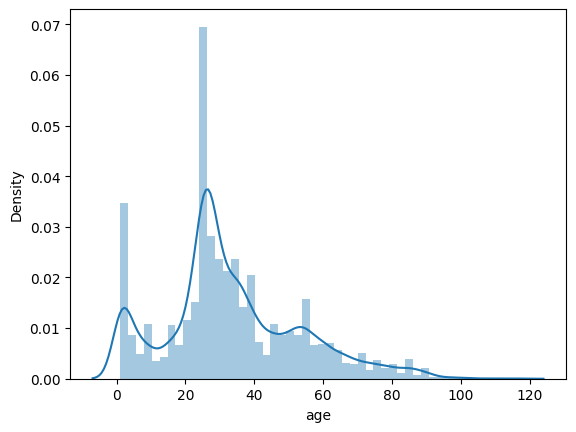

In [56]:
sns.distplot(df['age'])

In [57]:
import plotly.express as px
gender_mapping = ["Male", "Female"]
male_count = 0
ages = []
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
female_count = len(image_paths) - male_count
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    title = "Gender Distribution Donut Chart",
    height = 500
)
pie_chart.show()

In [58]:
print("Total  Males  Count: ",male_count)
print("Total Females Count: ",female_count)

Total  Males  Count:  12391
Total Females Count:  11317


<Axes: xlabel='gender', ylabel='count'>

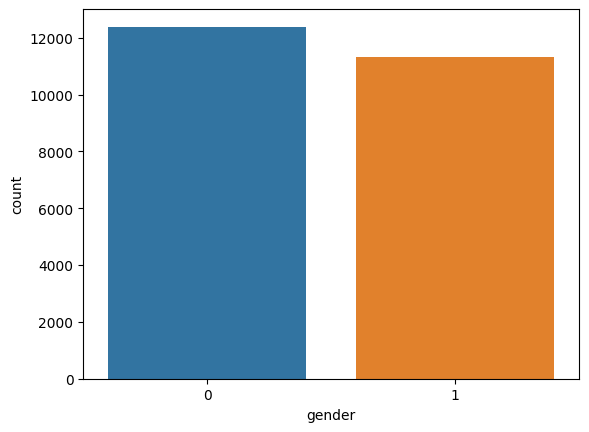

In [59]:
sns.countplot(x='gender', data=df)

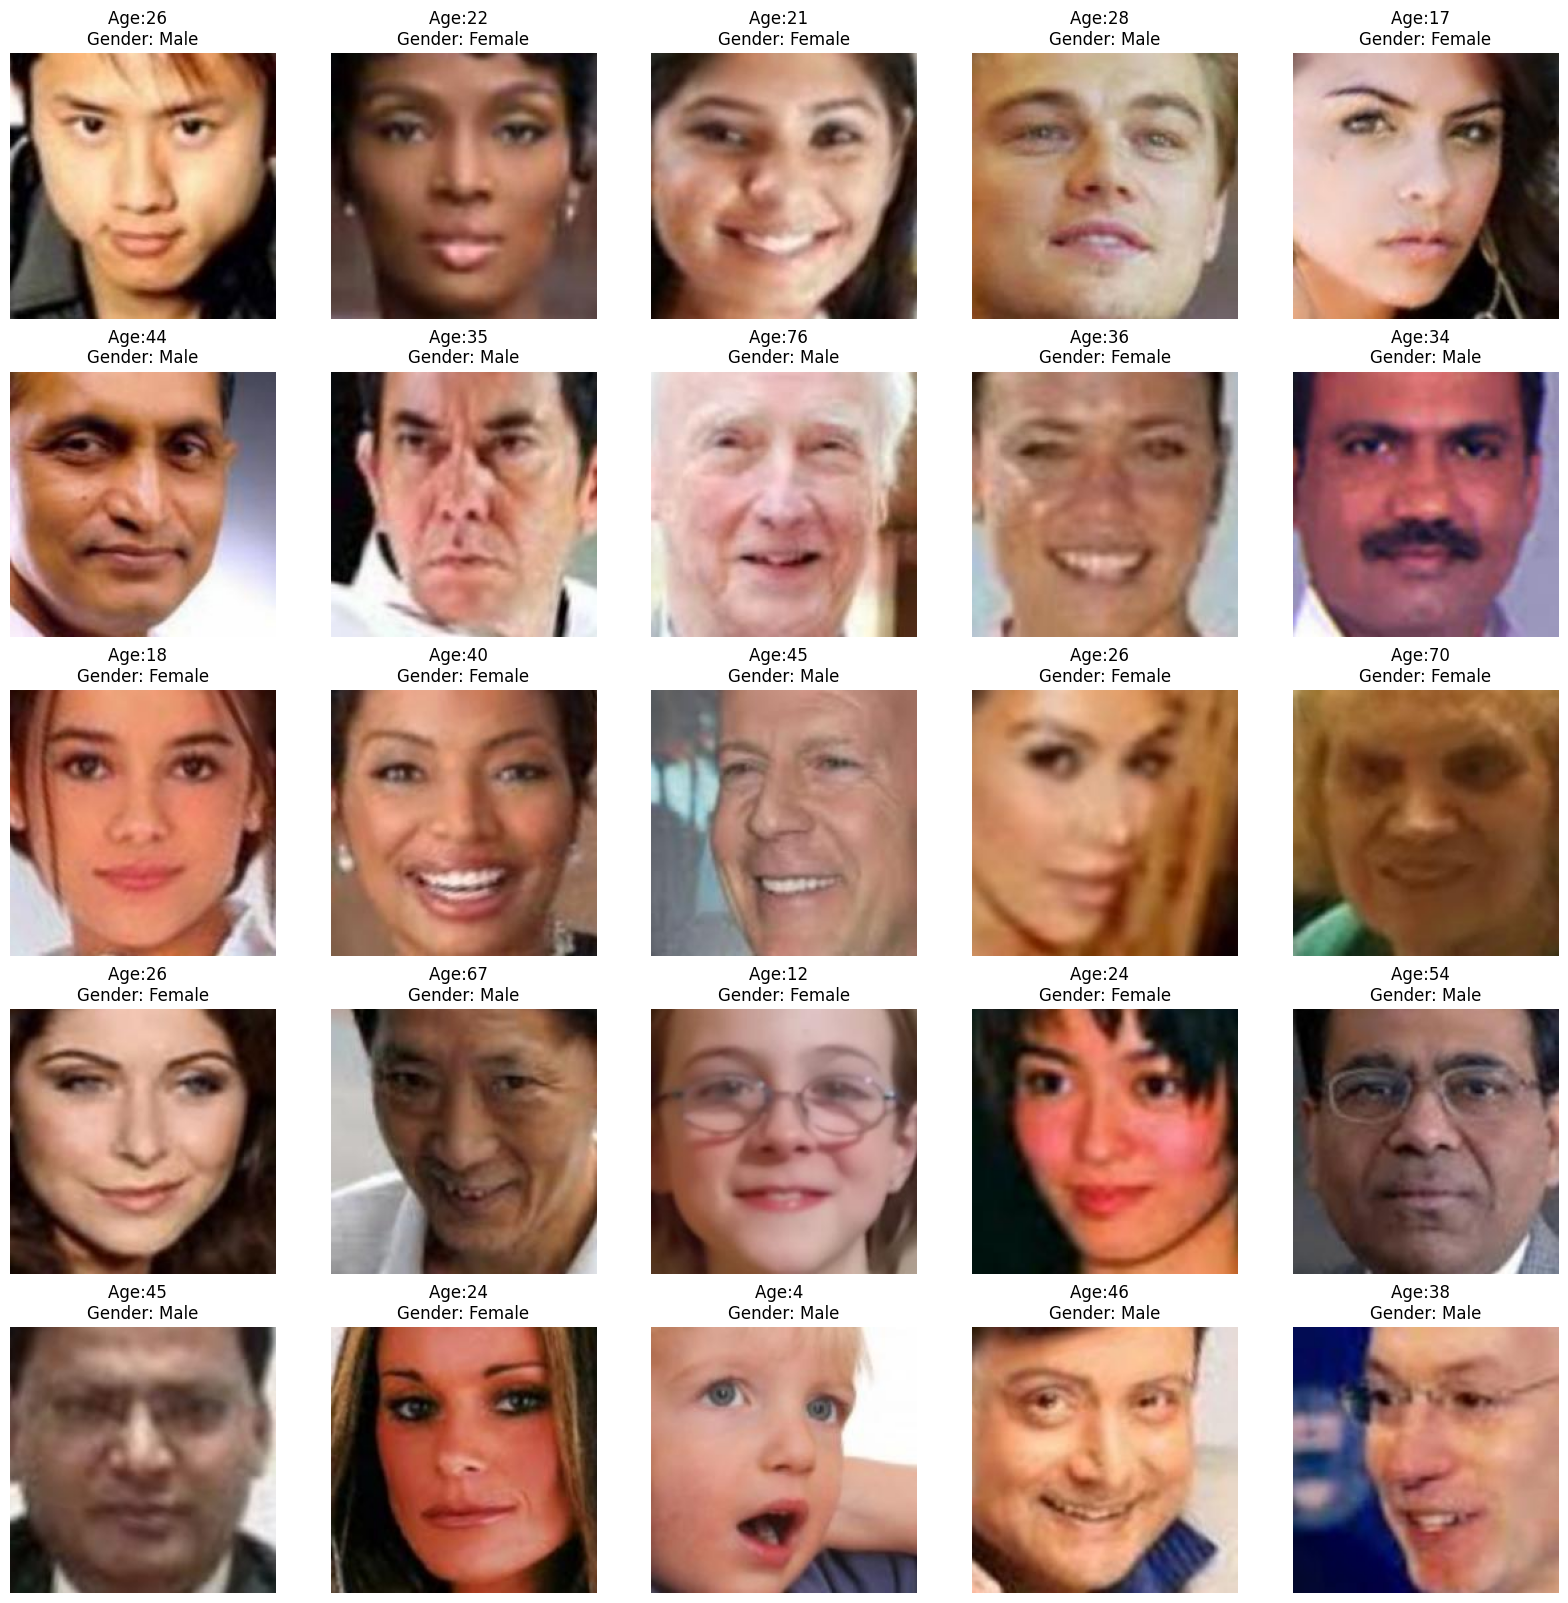

In [60]:
plt.figure(figsize=(20,20))
files = df.iloc[0:25]

for index,file,age,gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = Image.open(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age}  \nGender: {gender_dict[gender]}")
    plt.axis('off')

In [61]:
from keras.preprocessing.image import load_img

In [62]:
def extract_features(images):
    features=[]
    for image in tqdm(images):
        img=load_img(image,color_mode='grayscale')
        img=img.resize((128,128))
        img= np.array(img)
        features.append(img)
    features=np.array(features)
    features=features.reshape(len(features),128,128,1)
    return features

In [63]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [64]:
X.shape

(23708, 128, 128, 1)

In [65]:
X=X/255.0

In [66]:
y_gender= np.array(df['gender'])
y_age= np.array(df['age'])

In [67]:
input_shape = (128,128,1)


**MODEL CREATION**

In [68]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model

In [79]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

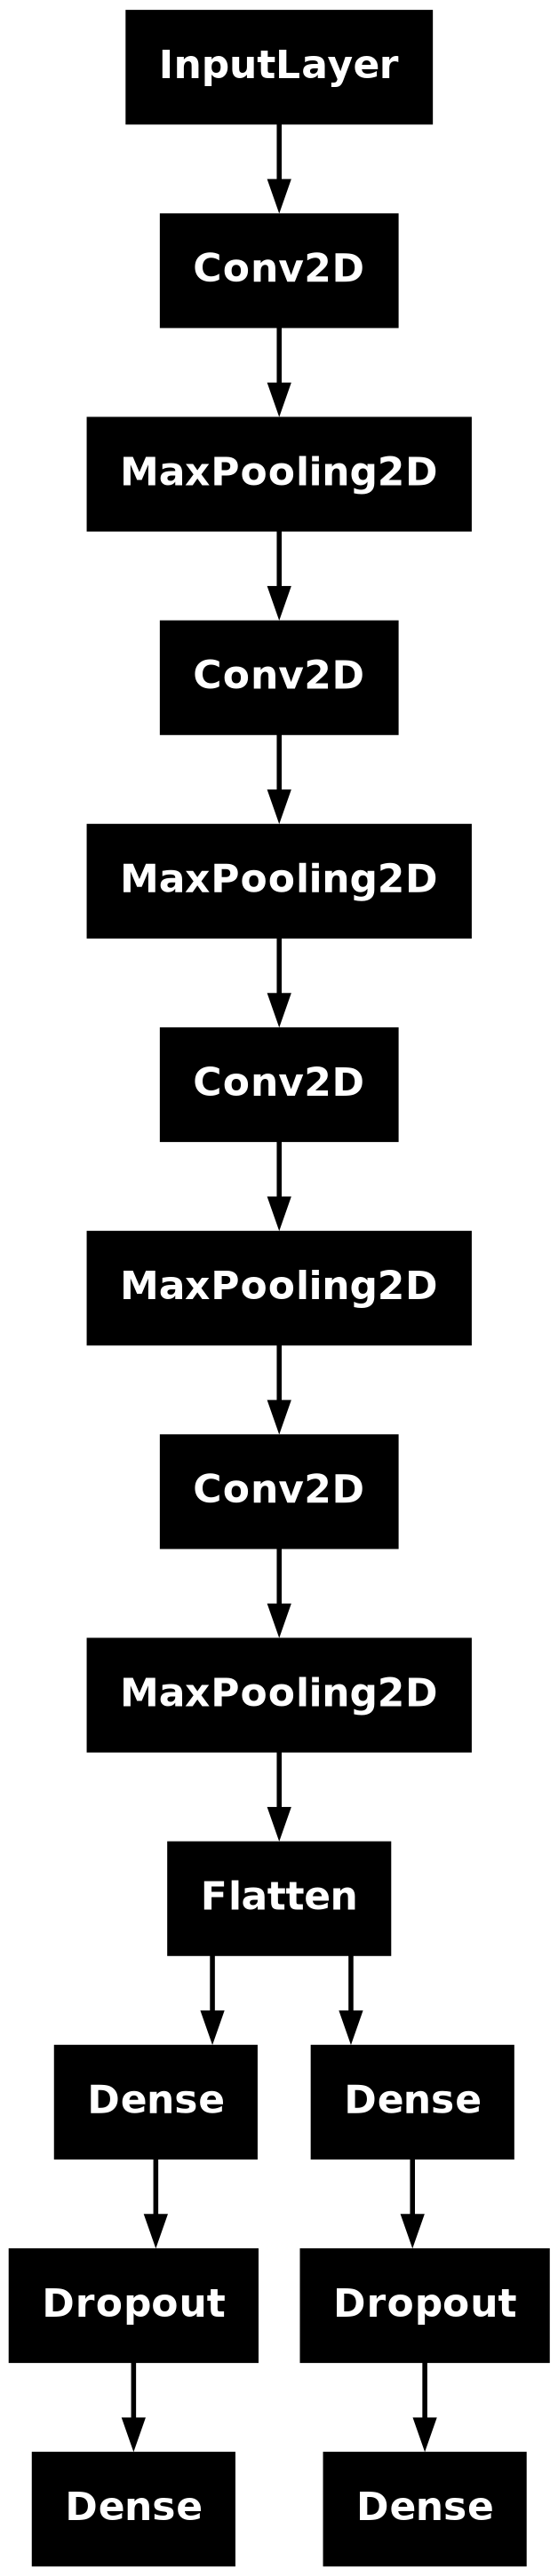

In [80]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [81]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
  6/593 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - age_out_mae: 32.2433 - gender_out_accuracy: 0.4833 - loss: 33.0582  

I0000 00:00:1711649609.643857      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711649609.664154      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - age_out_mae: 16.7962 - gender_out_accuracy: 0.5176 - loss: 17.5349

W0000 00:00:1711649630.643087      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711649632.312714      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - age_out_mae: 16.7937 - gender_out_accuracy: 0.5176 - loss: 17.5323 - val_age_out_mae: 12.4297 - val_gender_out_accuracy: 0.7178 - val_loss: 13.0143
Epoch 2/30
  7/593 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - age_out_mae: 14.7190 - gender_out_accuracy: 0.8040 - loss: 15.2185

W0000 00:00:1711649634.274492      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 11.9625 - gender_out_accuracy: 0.7442 - loss: 12.4834 - val_age_out_mae: 9.8462 - val_gender_out_accuracy: 0.8140 - val_loss: 10.2884
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 10.0080 - gender_out_accuracy: 0.8013 - loss: 10.4312 - val_age_out_mae: 8.7088 - val_gender_out_accuracy: 0.8273 - val_loss: 9.1021
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 8.7248 - gender_out_accuracy: 0.8295 - loss: 9.0933 - val_age_out_mae: 8.0409 - val_gender_out_accuracy: 0.8520 - val_loss: 8.3602
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 8.0142 - gender_out_accuracy: 0.8492 - loss: 8.3412 - val_age_out_mae: 7.4721 - val_gender_out_accuracy: 0.8577 - val_loss: 7.7765
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - age_out_mae: 7.5634 - gender_out_accuracy: 0.8645 - loss: 7.8693 - val_age_out_mae: 7.4980 - val_gender_out_accuracy: 0.8617 - val_loss: 7.7974
Epoch 

In [84]:
#will need improvements.